# 14wk-60: 자전거대여 / 하이퍼파라메터 튜닝

최규빈  
2023-12-01

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-xIGVpBAZn1QM5RGKSwsi1M&si=2KILF5Fg1zlJbf_r>

# 2. Imports

In [1]:
#!pip install autogluon.multimodal 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
#---#}
from autogluon.tabular import TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.common import space
#---#
import IPython
import os
import warnings
warnings.filterwarnings('ignore')

# 3. Data

`-` 자료 다운로드

In [2]:
!kaggle competitions download -c bike-sharing-demand

100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 830kB/s]
100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 830kB/s]

In [3]:
!unzip bike-sharing-demand.zip -d data

Archive:  bike-sharing-demand.zip
  inflating: data/sampleSubmission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          

In [4]:
sampleSubmission = pd.read_csv('data/sampleSubmission.csv')
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv') 

In [5]:
!rm -rf data
!rm bike-sharing-demand.zip

# 4. 기본전처리 및 분석 프로세스

`-` 전처리

In [7]:
def preprocessing(df_train,df_test):
    df_train_featured = df_train.copy()
    df_test_featured = df_test.copy()
    #----# 
    df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
    #--#
    df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
    df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
    df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
    df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
    #--#
    df_train_featured = df_train_featured.drop(['datetime'],axis=1)
    df_test_featured = df_test_featured.drop(['datetime'],axis=1)
    #--#
    df_train_featured = df_train_featured.drop(['atemp'],axis=1)
    df_test_featured = df_test_featured.drop(['atemp'],axis=1)
    return df_train_featured, df_test_featured

`-` 함수들

In [8]:
def plot(yhat,yyhat):
    df = pd.concat([
        df_train.assign(count_hat = yhat, dataset_type = 'train'),
        df_test.assign(count_hat = yyhat, dataset_type = 'test')
    ])
    df['datetime'] = pd.to_datetime(df['datetime'])
    sns.lineplot(
        df.sort_values('datetime')[:(24*28)],
        x='datetime',y='count',
        hue='dataset_type',
        linestyle='--',
        lw=0.8
    )
    sns.lineplot(
        df.sort_values('datetime')[:(24*28)],
        x='datetime',y='count_hat',
        hue='dataset_type',
        alpha=0.5,
        lw=3
    )
    fig = plt.gcf()
    fig.set_size_inches(8,2)
    plt.xticks(rotation=15); 
    fig.show()

In [9]:
def submit(yyhat):
    sampleSubmission['count'] = yyhat 
    sampleSubmission['count'] = sampleSubmission['count'].apply(lambda x: x if x>0 else 0)
    sampleSubmission.to_csv("submission.csv",index=False)
    !kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Message"
    !rm submission.csv

In [11]:
def auto(df_train, df_test):
    # step1 
    df_train_featured, df_test_featured = preprocessing(df_train, df_test) # preprocessing
    df_train_featured['count'] = np.log1p(df_train_featured['count']) # transform 
    # step2~4 
    yhat,yyhat = fit_predict(df_train_featured,df_test_featured)
    yhat = np.expm1(yhat) # inverse_trans
    yyhat = np.expm1(yyhat) # inverse_trans
    # 시각화 
    plot(yhat,yyhat)
    # 제출 
    submit(yyhat)

# 5. 하이퍼파라메터 튜닝

`-` 기본 HP

``` python
{
    "NN_TORCH": {},
    "GBM": [
        {"extra_trees": True, "ag_args": {"name_suffix": "XT"}},
        {},
        "GBMLarge"
    ],
    "CAT": {},
    "XGB": {},
    "FASTAI": {},
    "RF": [
        {"criterion": "gini", "ag_args": {"name_suffix": "Gini", "problem_types": ["binary", "multiclass"]}},
        {"criterion": "entropy", "ag_args": {"name_suffix": "Entr", "problem_types": ["binary", "multiclass"]}},
        {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
    ],
    "XT": [
        {"criterion": "gini", "ag_args": {"name_suffix": "Gini", "problem_types": ["binary", "multiclass"]}},
        {"criterion": "entropy", "ag_args": {"name_suffix": "Entr", "problem_types": ["binary", "multiclass"]}},
        {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
    ],
    "KNN": [
        {"weights": "uniform", "ag_args": {"name_suffix": "Unif"}},
        {"weights": "distance", "ag_args": {"name_suffix": "Dist"}}
    ]
}
```

`-` fit_predict 함수 수정

In [29]:
def fit_predict(df_train_featured, df_test_featured):
    # step1 
    # step2
    predictr= TabularPredictor(label='count',verbosity=False)
    # step3 
    hp = {
        "RF": [
            {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
        ]
    }
    predictr.fit(
        df_train_featured,
        hyperparameters = hp
    )
    # step4 
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    # display
    display(predictr.leaderboard())
    return yhat, yyhat 

100%|█████████████████████████████████████████| 243k/243k [00:02<00:00, 107kB/s]
Successfully submitted to Bike Sharing Demand

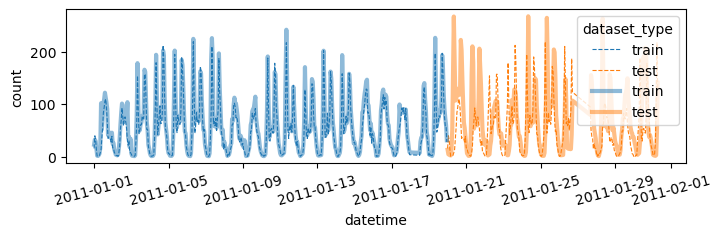

In [30]:
auto(df_train,df_test)

ref: <https://auto.gluon.ai/0.8.1/api/autogluon.tabular.models.html>

-   LightGBM model: <https://lightgbm.readthedocs.io/en/latest/>
-   CatBoost model: <https://catboost.ai/>
-   XGBoost model: <https://xgboost.readthedocs.io/en/latest/>
-   Random Forest model (scikit-learn):
    <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>
-   Extra Trees model (scikit-learn):
    <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier>
-   Linear model (scikit-learn):
    <https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html>

`-` 방금 돌린것은 아래와 결과가 동일함.

In [33]:
def fit_predict(df_train_featured, df_test_featured):
    # step1 
    # step2
    predictr= TabularPredictor(label='count',verbosity=False)
    # step3 
    hp = {
        "RF": [
            {"n_estimators":300, "criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
        ]
    }
    predictr.fit(
        df_train_featured,
        hyperparameters = hp
    )
    # step4 
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    # display
    display(predictr.leaderboard())
    return yhat, yyhat 

100%|█████████████████████████████████████████| 243k/243k [00:02<00:00, 117kB/s]
Successfully submitted to Bike Sharing Demand

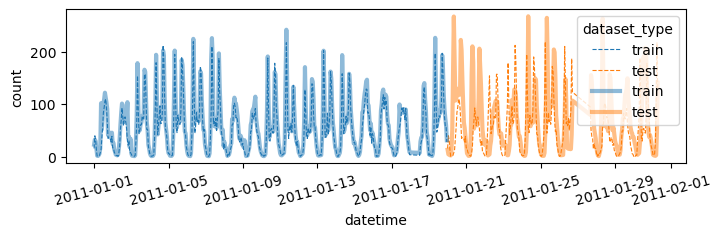

In [34]:
auto(df_train,df_test)

`-` 알아낸 방법?

In [45]:
df_train_featured, df_test_featured = preprocessing(df_train,df_test)

In [46]:
predictr= TabularPredictor(label='count',verbosity=False)
# step3 
hp = {
    "RF": [
        {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
    ]
}
predictr.fit(
    df_train_featured,
    hyperparameters = hp
)

In [52]:
predictr.info()['model_info']['RandomForestMSE']['hyperparameters']

`-` RF에서 더 다양한 파라메터를 실험해보자.

In [55]:
def fit_predict(df_train_featured, df_test_featured):
    # step1 
    # step2
    predictr= TabularPredictor(label='count',verbosity=False)
    # step3 
    hp = {
        "RF": [ {"criterion": "squared_error", "n_estimators":i, "max_leaf_nodes":j, "ag_args": {"name_suffix": f"({i},{j})"}} for i in [300,400,500] for j in [10000,15000]]
    }
    predictr.fit(
        df_train_featured,
        hyperparameters = hp
    )
    # step4 
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    # display
    display(predictr.leaderboard())
    return yhat, yyhat 

100%|█████████████████████████████████████████| 242k/242k [00:01<00:00, 136kB/s]
Successfully submitted to Bike Sharing Demand

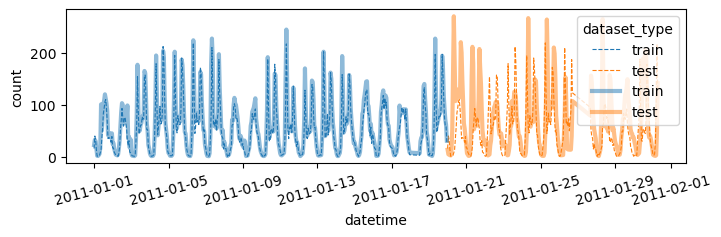

In [56]:
auto(df_train,df_test)